In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from src.models import SIRM, SIRT, SIRV
from helps import *

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def simple_parameter_grid(data_matrices, nrows, ncols, figsize=(10, 8), 
                         cmap='viridis', vmin=0, vmax=1, extent=[0, 1, 0, 6]):
    """
    Super duper simple version - just plot matrices with colorbars
    
    Args:
        data_matrices: List of 2D arrays to plot
        nrows, ncols: Grid dimensions
        figsize: Figure size
        cmap: Colormap
        vmin, vmax: Color scale limits
        
    Returns:
        fig, axes
    """
    # Create figure with extra column for colorbars
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows, ncols + 1, figure=fig, width_ratios=[1] * ncols + [0.05])
    
    # Create axes
    axes = np.empty((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            axes[i, j] = fig.add_subplot(gs[i, j])
    
    cbar_axes = []
    for i in range(nrows):
        cbar_axes.append(fig.add_subplot(gs[i, -1]))
    
    # Plot matrices
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            
            if idx < len(data_matrices):
                data = data_matrices[idx]
                im = axes[i, j].imshow(
                    np.flipud(data), 
                    cmap=cmap, 
                    vmin=vmin, 
                    vmax=vmax,
                    aspect='auto',
                    extent=extent
                )
                
                # Add colorbar for first column of each row
                if j == 0:
                    fig.colorbar(im, cax=cbar_axes[i])
    
    return fig, axes, cbar_axes

: 

In [ ]:
temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
rect_coords_M = [mus["pol"][0], mus["h"][0], mus["pol"][2]-mus["pol"][0], mus["h"][2]-mus["h"][0]]
rect_coords_T = [taus["pol"][0], taus["h"][0], taus["pol"][2]-taus["pol"][0], taus["h"][2]-taus["h"][0]]
rect_coords_V = [xis["pol"][0], xis["h"][0], xis["pol"][2]-xis["pol"][0], xis["h"][2]-xis["h"][0]]
# visualization parameters

colors_X = ['#66c2a4', '#238b45','#00441b']  # fixed polarization
colors_Y = ['#67001f', '#e7298a', '#df65b0'] # fixed homophily
my_map = discretize_cmaps("hot_r",21)
my_map.set_bad(color='gray')
cmaps = [my_map]
contour_values = [[0.25, 0.5, 0.75]]
contour_colors = [['#000','#000','#000']]
final_params={
        'Lx': Lx,  # Figure width in inches
        'Ly': Ly,  # Figure height in inches
        'xticks': [0, 0.5, 1.0],
        'yticks': [0, 3, 6],
        'xlim': [0, 1],
        'ylim': [0, 6]
    }

: 

In [ ]:

homophilic_tendency = {"m": 0, "M": 6, "n": 20}
pol_range = {"m": 0, "M": 1, "n": 20}


: 

In [ ]:
def calc_prediction_error(calibrated, baseline):
    return (calibrated - baseline)* 100



: 

In [30]:


# 1 ) calculate the TI for all the points in the range dictated by pols_M/homs_M, with mean = mus["mean"][1]
# 2 ) find the pol/hom that maximizes the TI and that minimizes it: (mp, mh) and (Mp, Mh)
# 3 ) calculate TI(t|mp, mh) and TI(t|Mp, mh)

def get_TI_curves(mus, PARAMS, model, beta_M, simulated_days = 10000):
    pol_range = np.linspace(mus["pol"][0], mus["pol"][2], 20)
    hom_range = np.linspace(mus["h"][0], mus["h"][2], 20)

    CB = PARAMS.copy()
    CB["fixed_mean"] = mus["mean"][1]
    CB["beta_M"] = beta_M

    results = sweep_two_parameters(
        model_module=model,
        param1_name="beta_params",
        param1_range=pol_range,
        param2_name="homophilic_tendency",
        param2_range=hom_range,
        custom_base_params=CB,
        simulated_days=simulated_days,
        population_size=5,
        batch_size=1000
    )
    TI = np.sum(results["final_state"]["R"], axis=2) + np.sum(results["final_state"]["I"], axis=2)

    min_idx = np.unravel_index(np.argmin(TI), TI.shape)
    max_idx = np.unravel_index(np.argmax(TI), TI.shape)

    min_pol, min_hom = pol_range[min_idx[0]], hom_range[min_idx[1]]
    max_pol, max_hom = pol_range[max_idx[0]], hom_range[max_idx[1]]

    S_min, I_min, R_min = run_single_simulation(min_pol, min_hom, mus["mean"][1], CB, model, simulated_days=simulated_days)
    S_max, I_max, R_max = run_single_simulation(max_pol, max_hom, mus["mean"][1], CB, model, simulated_days=simulated_days)
    S_base, I_base, R_base = run_single_simulation(0.0001, 0, mus["mean"][1], CB, model, simulated_days=simulated_days)

    TI_min = I_min + R_min
    TI_max = I_max + R_max
    TI_base = I_base + R_base

    
    return TI_min, TI_max, TI_base, (TI_min+TI_max)/2

def plot_TI_curves(TI_min, TI_max, TI_base, TI_mean, figsize = (1.307, 1.307)):
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    axs.plot(TI_min, color="black", linewidth=0.5, label="min")
    axs.plot(TI_max, color="black", linewidth=0.5)
    axs.fill_between(
        np.arange(len(TI_min)),
        TI_min,
        TI_max,
        color='#B3DE69',
        alpha=1
    )
    axs.plot(TI_base, color="black", linewidth=1, linestyle="--")
    axs.set_xlim(0, 1000)
    axs.set_ylim(0, 0.7)
    axs.set_xticks([0,500,1000])
    axs.set_yticks([0,0.3, 0.6])
    axs.set_xticklabels([])
    axs.set_yticklabels([])
   
    # calculate the percental increase or decrease by using the TT instead of the base
    prediction_error = calc_prediction_error(TI_mean[-1], TI_base[-1])
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    return fig, axs, prediction_error




In [39]:
M_min, M_max, M_base, M_mean = get_TI_curves(mus, PARAMS, SIRM, 0.4)
T_min, T_max, T_base, T_mean = get_TI_curves(taus, PARAMS, SIRT, 0.2)
V_min, V_max, V_base, V_mean = get_TI_curves(xis, PARAMS, SIRV, 0.2)



-48.05147
46.709484
10.216418


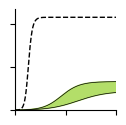

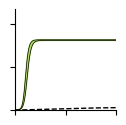

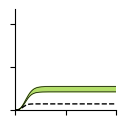

In [42]:
fig, axs, prediction_error = plot_TI_curves(M_min, M_max, M_base, M_mean)
print(prediction_error)
fig.savefig("figures/Fig_2/I(pol,hom)_M.pdf", bbox_inches="tight")
fig, axs, prediction_error = plot_TI_curves(T_min, T_max, T_base, T_mean)
print(prediction_error)
fig.savefig("figures/Fig_2/I(pol,hom)_T.pdf", bbox_inches="tight")
fig, axs, prediction_error = plot_TI_curves(V_min, V_max, V_base, V_mean)
print(prediction_error)
fig.savefig("figures/Fig_2/I(pol,hom)_V.pdf", bbox_inches="tight")

In [23]:
def run_all(R0, CB, spec, pols, homs, model, pol_baseline, hom_baseline, simulated_days = 10000):
    CB = PARAMS.copy()
    
    CB["beta_M"] = R0 * CB["recovery_rate"]
    CB["fixed_mean"] = spec["mean"][1]
    temp_test = sweep_two_parameters(
        model_module=model,
        param1_name="beta_params",              # parameter 1 name
        param1_range=pols,                      # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homs,                      # parameter 2 range
        custom_base_params=CB,
        simulated_days=simulated_days,
        population_size=5,
        batch_size=1000
    )
    temp_0 = sweep_two_parameters(
        model_module=model,
        param1_name="beta_params",              # parameter 1 name
        param1_range=pol_baseline,              # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=hom_baseline,              # parameter 2 range
        custom_base_params=CB,
        simulated_days=simulated_days,
        population_size=5,
        batch_size=1000
    )
    MAP_test = np.sum(temp_test["final_state"]["R"], axis=2) + np.sum(temp_test["final_state"]["I"], axis=2)
    MAP_0 = np.sum(temp_0["final_state"]["R"], axis=2) + np.sum(temp_0["final_state"]["I"], axis=2)
    return MAP_test, MAP_0

In [26]:
tau = 2/7 * 0.693
print(tau)










0.19799999999999998


In [37]:
R0s = np.linspace(1, 5, 100)
number_of_points_pol = 2
number_of_points_hom = 2

# first is for empirical data, then 0.25, 0.5, 0.75


precise_M_3 = np.zeros((len(R0s), number_of_points_pol, number_of_points_hom,4))
precise_T_3 = np.zeros((len(R0s), number_of_points_pol, number_of_points_hom,4))
precise_V_3 = np.zeros((len(R0s), number_of_points_pol, number_of_points_hom,4))

nope_M_3 = np.zeros((len(R0s),4))
nope_T_3 = np.zeros((len(R0s),4))
nope_V_3 = np.zeros((len(R0s),4))

pols_M = {"m": mus["pol"][0], "M": mus["pol"][2], "n": number_of_points_pol}
homs_M = {"m": mus["h"][0], "M": mus["h"][2], "n": number_of_points_hom}

pols_T = {"m": taus["pol"][0], "M": taus["pol"][2], "n": number_of_points_pol}
homs_T = {"m": taus["h"][0], "M": taus["h"][2], "n": number_of_points_hom}

pols_V = {"m": xis["pol"][0], "M": xis["pol"][2], "n": number_of_points_pol}
homs_V = {"m": xis["h"][0], "M": xis["h"][2], "n": number_of_points_hom}


pol_baseline = {"m": 0.0001, "M": 0.0001, "n": 1}
hom_baseline = {"m": 0 , "M": 0 , "n": 1}

from copy import deepcopy

means = [0, 0.25, 0.5, 0.75]

for j, mean in enumerate(means):
    temp = read_json("./parameters.json")
    mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
    mus2  = deepcopy(mus)
    taus2 = deepcopy(taus)
    xis2 = deepcopy(xis)
    if j > 0:
        mus2["mean"][1] = mean
        taus2["mean"][1] = mean
        xis2["mean"][1] = mean
    for i, R0 in enumerate(R0s):
        print(mean, R0)
        #print(mus2["mean"][1], taus2["mean"][1], xis2["mean"][1])
        A, B = run_all(R0, PARAMS, mus2, pols_M, homs_M, SIRM, pol_baseline, hom_baseline)

        precise_M_3[i, :, :, j] = A
        nope_M_3[i, j] = B

        A, B = run_all(R0, PARAMS, taus2, pols_T, homs_T, SIRT, pol_baseline, hom_baseline)

        precise_T_3[i, :, :, j] = A
        nope_T_3[i, j] = B

        A, B = run_all(R0, PARAMS, xis2, pols_V, homs_V, SIRV, pol_baseline, hom_baseline)

        precise_V_3[i, :, :, j] = A
        nope_V_3[i, j] = B
    print("mus = ", mus)
    print("taus = ", taus)
    print("xis = ", xis)
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    

0 1.0
0 1.0404040404040404
0 1.0808080808080809
0 1.121212121212121
0 1.1616161616161615
0 1.202020202020202
0 1.2424242424242424
0 1.2828282828282829
0 1.3232323232323233
0 1.3636363636363638
0 1.404040404040404
0 1.4444444444444444
0 1.4848484848484849
0 1.5252525252525253
0 1.5656565656565657
0 1.606060606060606
0 1.6464646464646466
0 1.6868686868686869
0 1.7272727272727273
0 1.7676767676767677
0 1.8080808080808082
0 1.8484848484848486
0 1.8888888888888888
0 1.9292929292929295
0 1.9696969696969697
0 2.0101010101010104
0 2.0505050505050506
0 2.090909090909091
0 2.1313131313131315
0 2.1717171717171717
0 2.212121212121212
0 2.2525252525252526
0 2.2929292929292933
0 2.3333333333333335
0 2.3737373737373737
0 2.4141414141414144
0 2.4545454545454546
0 2.494949494949495
0 2.5353535353535355
0 2.575757575757576
0 2.6161616161616164
0 2.6565656565656566
0 2.6969696969696972
0 2.7373737373737375
0 2.7777777777777777
0 2.8181818181818183
0 2.858585858585859
0 2.8989898989898992
0 2.939393939393

In [34]:
min_M_4 = np.zeros((len(R0s),4))
min_T_4 = np.zeros((len(R0s),4))
min_V_4 = np.zeros((len(R0s),4))
max_M_4 = np.zeros((len(R0s),4))
max_T_4 = np.zeros((len(R0s),4))
max_V_4 = np.zeros((len(R0s),4))

pct_M_min4 = np.zeros((len(R0s),4))
pct_T_min4 = np.zeros((len(R0s),4))
pct_V_min4 = np.zeros((len(R0s),4))
pct_M_max4 = np.zeros((len(R0s),4))
pct_T_max4 = np.zeros((len(R0s),4))
pct_V_max4 = np.zeros((len(R0s),4))


def percent_change(base, compare):
    return (compare - base)*100


for k in range(4):
    min_M_4[:,k] = np.min(precise_M_3[:,:,:,k], axis=(1, 2))
    min_T_4[:,k] = np.min(precise_T_3[:,:,:,k], axis=(1, 2))
    min_V_4[:,k] = np.min(precise_V_3[:,:,:,k], axis=(1, 2))
    max_M_4[:,k] = np.max(precise_M_3[:,:,:,k], axis=(1, 2))
    max_T_4[:,k] = np.max(precise_T_3[:,:,:,k], axis=(1, 2))
    max_V_4[:,k] = np.max(precise_V_3[:,:,:,k], axis=(1, 2))

for k in range(4):
    pct_M_min4[:,k] = percent_change(nope_M_3[:,k], min_M_4[:,k])
    pct_T_min4[:,k] = percent_change(nope_T_3[:,k], min_T_4[:,k])
    pct_V_min4[:,k] = percent_change(nope_V_3[:,k], min_V_4[:,k])
    pct_M_max4[:,k] = percent_change(nope_M_3[:,k], max_M_4[:,k])
    pct_T_max4[:,k] = percent_change(nope_T_3[:,k], max_T_4[:,k])
    pct_V_max4[:,k] = percent_change(nope_V_3[:,k], max_V_4[:,k])


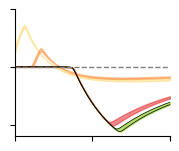

In [43]:
fig, axs = plt.subplots(1,1, figsize=(2, 1.65))


axs.fill_between(R0s, pct_M_min4[:,0], pct_M_max4[:,0], color="#B3DE69", alpha=1)
axs.fill_between(R0s, pct_M_min4[:,1], pct_M_max4[:,1], color="#fed976", alpha=0.5)
axs.fill_between(R0s, pct_M_min4[:,2], pct_M_max4[:,2], color="#fd8d3c", alpha=0.5)
axs.fill_between(R0s, pct_M_min4[:,3], pct_M_max4[:,3], color="#e31a1c", alpha=0.5)
axs.plot(R0s, pct_M_min4[:,0], color="black", linewidth=0.5, label="Increase from min to nope")
axs.plot(R0s, pct_M_max4[:,0], color="black", linewidth=0.5, label="Increase from nope to max")
#axs.axvline(x=4, color="black", linestyle="--")
axs.set_xlim(1,5)
axs.axhline(0, color="gray", linewidth=1, linestyle="--")
axs.set_xticks([1, 3, 5])
axs.set_xticklabels([])
axs.set_ylim(-60, 50)
axs.set_yticks([-50, 0, 50])
axs.set_yticklabels([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
fig.savefig("figures/Fig_3/predictionerror(R0)_M_3.pdf", bbox_inches="tight")



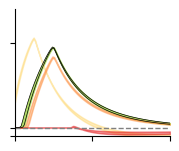

In [44]:

fig, axs = plt.subplots(1,1, figsize=(2, 1.65))


axs.fill_between(R0s, pct_T_min4[:,0], pct_T_max4[:,0], color="#B3DE69", alpha=1)
axs.fill_between(R0s, pct_T_min4[:,1], pct_T_max4[:,1], color="#fed976", alpha=0.5)
axs.fill_between(R0s, pct_T_min4[:,2], pct_T_max4[:,2], color="#fd8d3c", alpha=0.5)
axs.fill_between(R0s, pct_T_min4[:,3], pct_T_max4[:,3], color="#e31a1c", alpha=0.5)
axs.plot(R0s, pct_T_min4[:,0], color="black", linewidth=0.5, label="Increase from min to nope")
axs.plot(R0s, pct_T_max4[:,0], color="black", linewidth=0.5, label="Increase from nope to max")
#axs.axvline(x=2, color="black", linestyle="--")
axs.set_xlim(1,5)
axs.axhline(0, color="gray", linewidth=1, linestyle="--")
axs.set_xticks([1, 3, 5])
axs.set_xticklabels([])
axs.set_ylim(-5, 70)
axs.set_yticks([-5, 0, 50])
axs.set_yticklabels([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
fig.savefig("figures/Fig_3/predictionerror(R0)_T_3.pdf", bbox_inches="tight")


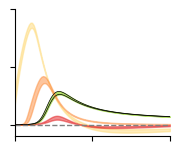

In [45]:

fig, axs = plt.subplots(1,1, figsize=(2, 1.65))

axs.fill_between(R0s, pct_V_min4[:,0], pct_V_max4[:,0], color="#B3DE69", alpha=1)
axs.fill_between(R0s, pct_V_min4[:,1], pct_V_max4[:,1], color="#fed976", alpha=0.5)
axs.fill_between(R0s, pct_V_min4[:,2], pct_V_max4[:,2], color="#fd8d3c", alpha=0.5)
axs.fill_between(R0s, pct_V_min4[:,3], pct_V_max4[:,3], color="#e31a1c", alpha=0.5)
axs.plot(R0s, pct_V_min4[:,0], color="black", linewidth=0.5, label="Increase from min to nope")
axs.plot(R0s, pct_V_max4[:,0], color="black", linewidth=0.5, label="Increase from nope to max")
#axs.axvline(x=2, color="black", linestyle="--")
axs.set_xlim(1,5)
axs.axhline(0, color="gray", linewidth=1, linestyle="--")
axs.set_xticks([1, 3, 5])
axs.set_xticklabels([])
axs.set_ylim(-5, 50)
axs.set_yticks([0, 25, 50])
axs.set_yticklabels([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
fig.savefig("figures/Fig_3/predictionerror(R0)_V_3.pdf", bbox_inches="tight")